Code for this post can be found [here](https://github.com/pvonglehn/data-science-concepts/blob/master/Volcanoes.ipynb)  

Poisson processes are used to model events which occur independently of each other over time and with a constant rate. For example radioactive decay, emission of photons from a weak source and telephone calls to a customer service center can all be modelled as Poisson processes. 

Poisson process models can be used to estimate useful properties of these systems. For example in planning how many customer service employees to hire it is important to know not just the average number of calls in a day, but also the probability of receiving more X calls in a day. This will tell you how many people to hire in order to keep the probability of being overwhelmed on any given day acceptably low.   

### Modelling volcanic eruptions as Poisson processes 

It has already been established in the volcanology literature that volcanic eruptions can be well modelled as Poisson processes [[1]](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5931572/). In this notebook we will see if we can model all volcanic eruptions in the world between 1950 and 2019.

Poisson processes are modelled by a single parameter $\lambda$, which represents the mean number of occurrences (known as arrivals) per unit time.

Here we estimate $\lambda$ from the interarrival times (times between eruptions) and find $\hat \lambda = 0.09530$  eruptions per day. We estimate $\lambda$ again from the number of eruptions per year and get $\hat \lambda = 34.77 $ per year equivalent to $0.09526$ per day, which is consistent with the estimation of lambda from the interarrival times.

We also check the validity of our assumptions that the eruptions are independent events and that the rate of eruptions is consistent over time.


[1]:Papale P. Global time-size distribution of volcanic eruptions on Earth. Sci Rep. 2018;8(1):6838. Published 2018 May 1. doi:10.1038/s41598-018-25286-y



# Getting the data

The data for this study was downloaded from the Smithsonian Institution National Museum of Natural History Global Volcanism Program [database](https://volcano.si.edu/). The data is downloadable in the form of an excel spreadsheet from their website. You can download the reduced data set from my github repo [here](https://github.com/pvonglehn/data-science-concepts/blob/master/data/volcanos.csv)

Here I have included all confirmed volcanic eruptions between 1950 and 2019 and am treating the start date as the date of occurence.


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import pathlib
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf

def load_format_data(file):
    '''read data into dataframe clean and format'''
    
    df = pd.read_excel(file,skiprows=[0],sheet_name="Eruption List")

    # Drop rows without years
    df = df.dropna(subset=['Start Year','Start Month','Start Day'])

    # Select only between 1950 and 2020 (before 1950 not all eruptions have start and months)
    df = df.loc[(df["Start Year"] > 1950)
               & (df["Start Year"] < 2020)
               ]

    # Select only confirmed eruptions
    df = df.loc[df["Eruption Category"] == "Confirmed Eruption"]

    # Convert dates to datetime object
    df["dt"] = pd.to_datetime(df[['Start Year','Start Month','Start Day']]
                               .astype(int)
                               .astype(str)
                               .agg('-'.join, axis=1)
                                  )
    
    # Sort in ascending order
    df = df.sort_values("dt") 
    df["year"] = df["dt"].dt.year
    df = df.reset_index()
    
    
    columns = ["Eruption Number","dt","year"]
    
    return df[columns]

file = pathlib.Path().joinpath("data","GVP_Eruption_Results_all.xlsx")
df = load_format_data(file)

# Save stripped down data as csv
save_file = pathlib.Path().joinpath("data","volcanoes.csv")
df.to_csv(save_file)

## Interarrival times
### Independence of interarrival times
The interarrival time is the time between successive occurrences. An important assumption for a Poisson process to be a valid model is that the occurrences are independent of each other. One indicator that the occurrences are independent is if the interarrival times are not correlated with each other. 

In the code below we first calculate the interarrival times and then we calculate the autocorrelation of the interarrival times. The autocorrelation plot shows how correlated the arrival at time $n$ is with time $n + 1, n + 2 ...$. We can see in the plot below that the arrival times are uncorrelated which supports our assumption that the arrival times are independent of each other.

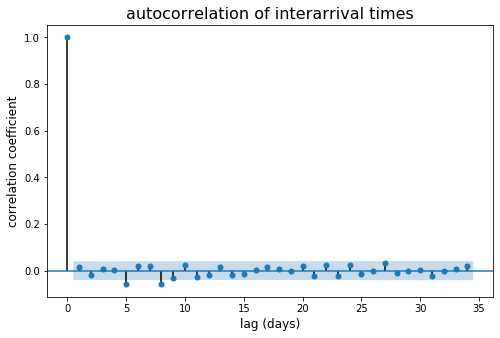

In [2]:
def get_interarrival_times(df):
    '''get times between eruptions (in days)'''
    
    Y = (df.iloc[1:]
           .apply(lambda row: row["dt"] - df.iloc[row.name - 1]["dt"],axis=1)
           .dt.days
           .values
        )

    return Y

def plot_autocorrelation(Y):
    '''plot autocorrelation of arrival times'''
    
    fig, ax = plt.subplots(figsize=(8,5))
    _ = plot_acf(np.array(Y),ax=ax)
    ax.set_title("autocorrelation of interarrival times",fontsize=16)
    ax.set_xlabel("lag (days)",fontsize=12)
    ax.set_ylabel("correlation coefficient",fontsize=12)
    
Y = get_interarrival_times(df)

plot_autocorrelation(Y)


## Modelling interarrival times

A Poisson process is a single parameter model. This parameter is the arrival rate $\lambda$ and is equal to the mean number of occurences (known as arrivals) per unit of time.

The probability density function (PDF) for the interarrival time in a Poisson process is an exponential distribution with parameter lambda, given by the formula below.

$$\tag{1} f_{Y}(y) = \lambda e^{-\lambda y}$$

## Maximum likelihood estimation of $\lambda$

To estimate the value of $\lambda$ based on the data we have we will perform a maximum likelihood estimation. As the events are independent, the likelihood of the whole data of interarrival times is the product of the probability of each individual arrival time. We can then take the log of the likelihood, differentiate and set the differential to 0 to find the optimal value of $\lambda$.

 $$ \tag{2} L = \prod_{i=1}^n\lambda e^{-\lambda y_i}  $$
 
 $$ \tag{3} \log(L) = \sum_{i=1}^n(\log\lambda -\lambda y_i)$$
 
 $$ \tag{4} \frac {\partial {\log(L)}}{\partial{\lambda}} = \frac{n}{\lambda} - \sum_{i=1}^ny_i = 0$$
 
 $$ \tag{5} \lambda = \frac{n}{\sum_{i=1}^ny_i}$$

maximum likelihood estimate for lambda from interarrival times data = 0.09530 eruptions per day


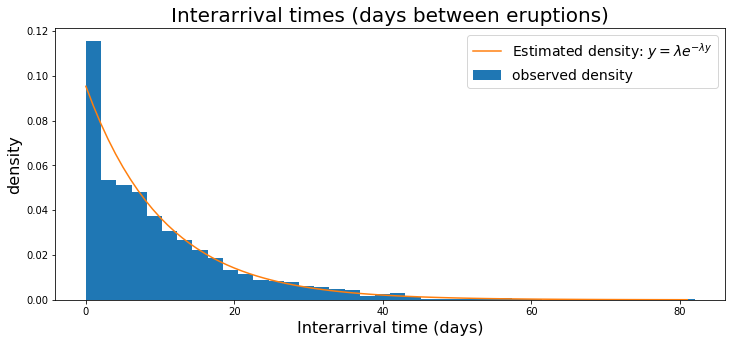

In [3]:
def expon(lambda_,x):
    '''pdf of exponential random variable'''
    
    return lambda_*np.exp(-lambda_*x)

expon = np.vectorize(expon)

def max_likelihood(Y):
    '''find maximum likelihood estimate of lambda'''

    n = Y.shape[0]
    
    return n/Y.sum()


def plot_arrival_times(Y,lambda_hat):
    '''plot distribution of interarrival times and the estimate for lambda'''
    fix,ax = plt.subplots(figsize=(12,5))
    x = np.arange(0,max(Y))
    y = expon(lambda_hat,x)
    _ = ax.hist(Y,density=True,bins=40,label="observed density")
    ax.plot(x,y,label="Estimated density: $y = \lambda e^{-\lambda y}$")
    ax.set_ylabel("density",fontsize=16)
    ax.set_xlabel("Interarrival time (days)",fontsize=16)
    ax.set_title("Interarrival times (days between eruptions)",fontsize=20)
    ax.legend(fontsize=14)
    
lambda_hat = max_likelihood(Y)

print(f"maximum likelihood estimate for lambda from interarrival times data = {lambda_hat:.5f} eruptions per day")

plot_arrival_times(Y,lambda_hat)

## Time homogeneity

Another important assumption for the Poisson process to be a valid model is time homogeneity. That is that the arrival rate is constant over time. In the code below we split the arrivals into ten chunks and calculate $\lambda$ using the maximum likelihood estimation for each one. We see that $\lambda$ is fairly consistent over time, deviating by a maximum of 13% of the mean, which supports the validity of our assumption of time homogeneity of lambda.

In [4]:
def calc_deviation(Y,chunks=10):
    '''calculate maximum deviation of lambda over time'''
    
    chunks = np.array_split(Y,chunks)
    lambdas = np.array([ max_likelihood(y) for y in chunks ])
    mean = lambdas.mean()
    above = abs(lambdas.max() - mean)
    below = abs(lambdas.min() - mean)
    highest_deviation = max(above,below)
    highest_deviation_pct = 100*(highest_deviation/mean)

    return highest_deviation_pct

print(f"maximum deviation of lambda from mean = {calc_deviation(Y):.2f}%")

maximum deviation of lambda from mean = 13.27%


## Eruptions per year

The Poisson process model can also be used to calculate probabilities of the number of arrivals per unit time - in our case the number of eruptions per year.

### Number of occurences per unit time

The PDF for the number of occurences per unit time (k) is given below in equation 6. Again we can estimate $\lambda$ with maximum likelihood estimation. To do that we will count up all of the eruptions per year $k_j$ in all $m$ years. We then get the total likelihood by taking the product of all the individual likelihoods for each year. Then we differentiate the log likelihood and set the differential to 0 to find $\lambda$ using equation 10.

$$\tag{6}  P_K(k) = \frac{\lambda^k e^{-\lambda}}{k!}$$

$$\tag{7}  L = \prod_{j=1}^m\frac{\lambda^{k_j} e^{-\lambda}}{k_j!}  $$

$$\tag{8}  \log(L) = \sum_{j=1}^n (k \log\lambda -\lambda - \log k!)$$

$$\tag{9}  \frac {\partial {\log(L)}}{\partial{\lambda}} = \sum_{j=1}^n (\frac{k}{\lambda} - 1) = 0$$

$$\tag{10}  \lambda = \frac{\sum_{j=1}^n k_j}{n} $$

maximum likelihood estimate for lambda from eruptions per year data = 34.77 per year 
or 0.09526 per day


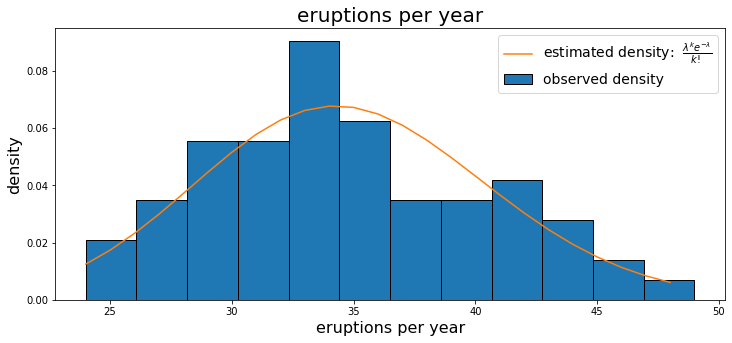

In [5]:
def max_likelihood_counts(counts):
    '''maximum likelihood estimation of lambda from counts per year'''    
    
    n = len(counts)

    return counts.sum()/n

def poisson_pmf(k,lambda_):
    '''PMF for Poisson distribution - probability of k events in time interval'''
    
    return ((lambda_**k)*np.exp(-lambda_))/np.math.factorial(k)

poisson_pmf = np.vectorize(poisson_pmf)


def plot_poisson(counts,lambda_):
    bin_size=2
    counts = df.groupby(["year"])["Eruption Number"].count().values
    max_counts = max(counts)
    min_counts = min(counts)
    x = np.arange(min_counts,max_counts)
    n_bins = bins=(max_counts-min_counts)//bin_size
    
    fig, ax = plt.subplots(figsize=(12,5))
    (df.groupby(["year"])["Eruption Number"]
       .count()
       .hist(density=True,bins=n_bins,grid=False,edgecolor="black",ax=ax,label="observed density")
    )
    ax.plot(x,poisson_pmf(x,lambda_hat_counts),label="estimated density:  " + r"$\frac{\lambda^k e^{-\lambda}}{k!}$")
    
    ax.set_ylabel("density",fontsize=16)
    ax.set_xlabel("eruptions per year",fontsize=16)
    ax.set_title("eruptions per year",fontsize=20)
    ax.legend(fontsize=14)


# Count eruptions per year
counts = df.groupby(["year"])["Eruption Number"].count().values

# Get maximum likelihood estimate for lambda from counts per year data
lambda_hat_counts = max_likelihood_counts(counts)

print(f"maximum likelihood estimate for lambda from eruptions per year data = {lambda_hat_counts:.2f} per year ")
print(f"or {lambda_hat_counts/365:.5f} per day")


plot_poisson(counts,lambda_hat_counts)

## Concluding remarks

The PDFs for the interarrival times and for the number of eruptions per year as derived from the Poisson model with our estimated $\lambda$ fit the observed distributions very well as we can see by visual inspection of the distributions. As we have also convinced ourselves that our assumptions about independence and time homogeneity are valid, we can conclude that worldwide volvanic eruptions can be reasonably modelled as Poisson processes (at least to a first approximation).